In [29]:
%run "../PyUtils/common.ipynb"
%run "../include-common.ipynb"
%run "../PyUtils/ShowExcel.ipynb"
%run "../PyUtils/ExcelFormulas.ipynb"
import networkx as nx
from networkx.readwrite import json_graph


<IPython.core.display.Javascript object>

In [6]:
wb, ws, genjs, df2 =openFileAndShow( file="test1.xlsx", tname= 't1', sheetname=0)

In [7]:
def RANGE_1(f='A1:B1'):
    f = f.lower()
    n1=0;
    n2=0;
    coords = []
    cellad = []
    if (f.startswith("r[")):
        n1 = re.findall(r'\d+', f)
        n2= list(map(int, n1))
        coords.append(n2);
    else:
        for i in openpyxl.utils.cols_from_range(f): 
            for j in i: 
                xy = coordinate_from_string(j)
                col = column_index_from_string(xy[0])
                row = xy[1]
                coords.append( (row, col));
                cellad.append(j)
    return coords, cellad
    

def RANGE(f='A1:B1', ws=ws, df=df2, data=True):
    cs,ca = RANGE_1(f)
    ret = []
    if (ws is None):
        return cs, ret
    for c in cs:
        row=c[0];
        column=c[1];
        if ( not data ):
            v = ws.cell(row=row, column=column)
            d = v.value
        else:
            d = df.loc[row-1][column-1]
        #print(c[0], c[1], v.value, v)
        ret.append(d)
        
    if (len(ret) == 1):
        ret = ret[0]
    return ret
    
def IF(*args):
    o = '=>'
    for k, v in enumerate(args):
        o +=  ('{1}'.format(k,v ))
    r = "IF: " + o;
    print(r)
    return r;
        
def AND(*args):
    o = '=>'
    for k, v in enumerate(args):
        o +=  ('{}{}'.format(k, v))
    r = "AND: " + o;
    print(r)
    return r;
      
def SUM(*args):
    o = '=>'
    ret = 0;
    for k, v in enumerate(args):
        ret += np.array(v).sum()
        o +=  ('{}{}'.format(k, v))
    r = "SUM: " + o;
    #print(r)
    return ret;

#IF(AND(RANGE('R[23]C[11]')>=15,RANGE('R[24]C[11]')>=20),RANGE('R53C3'),SUM(RANGE('A1:B1'))) 


In [8]:
gp = ExcelParser()
def pparse(f, p = gp):
    output = ""
    p.parse(f)
    if p.tokens:
        for t in p.tokens.items:
            if   t.ttype == p.TOK_TYPE_FUNCTION and t.tsubtype == p.TOK_SUBTYPE_START:     output += t.tvalue + "("
            elif t.ttype == p.TOK_TYPE_FUNCTION and t.tsubtype == p.TOK_SUBTYPE_STOP:      output += ")"
            elif t.ttype == p.TOK_TYPE_SUBEXPR  and t.tsubtype == p.TOK_SUBTYPE_START:     output += "("
            elif t.ttype == p.TOK_TYPE_SUBEXPR  and t.tsubtype == p.TOK_SUBTYPE_STOP:      output += ")"
            elif t.ttype == p.TOK_TYPE_OPERAND  and t.tsubtype == p.TOK_SUBTYPE_RANGE:     output += "RANGE('{}')".format(t.tvalue)
            elif t.ttype == p.TOK_TYPE_OPERAND  and t.tsubtype == p.TOK_SUBTYPE_TEXT:      output += "\"" + t.tvalue + "\""
            elif t.ttype == p.TOK_TYPE_OP_IN    and t.tsubtype == p.TOK_SUBTYPE_INTERSECT: output += " "                    

            else: output += t.tvalue
    return output;

def rcToCell(row=0,ccol=0, ttuple =None):
    if ( ttuple is not None and ttuple):
        ret = openpyxl.utils.get_column_letter(ttuple[0])+str(ttuple[1])
    else:
        ret = openpyxl.utils.get_column_letter(col)+str(row)
    return ret;

In [9]:
#f= '=SUM((D9:D11, 35, (E9:E11,F9:F11)))+$A2'
#f= '= -A3 + A1 *$A2'
#f = 'IF(AND(R[23]C[11]>=55,R[24]C[11]>=20), R53C3, SUM(A1:B1))'
f = '=SUM(C2:C9)'
f = '=SUM(B2:B9,  35)'

output = pparse(f)
print(output, " #: <", f)

n1 = re.findall(r'RANGE\(.*?\)', output)
for j in n1:
    j = j.replace('RANGE', 'RANGE_1')
    o = eval(j)
    print (o[1])
#
SUM(RANGE('B2:B9'),35)  #: < =SUM(B2:B9,  35)


SUM(RANGE('B2:B9'),35)  #: < =SUM(B2:B9,  35)
['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']


251

In [10]:
G=nx.DiGraph()

f = getFormulas(ws,df2)     
AllCells={}
group = 0;
for c in f.keys():
    v = f[c]
    output = pparse(v)
    n1 = re.findall(r'RANGE\(.*?\)', output)
    cells = []
    
    myCell = rcToCell(ttuple=c)   
    AllCells[myCell] = myCell;
    
    for j in n1:
        j = j.replace('RANGE', 'RANGE_1')
        o = eval(j)
        cells.append( (o[1]) )
        
        for ct in o[1]: 
            AllCells[ct]  = ct
    
    G.add_node(myCell, group=group, r=12, fixed=True)
    othCells = list(np.array(cells).flatten())
    G.add_nodes_from(othCells, group=(group+1), r=8, fixed=False)
    for c in othCells:
        G.add_edge(c, myCell, );
        
    group += 2
    #if ( group > 4): break;
    print ("{:9}, {} {}".format(myCell,v, cells) )

d = json_graph.node_link_data(G, ) 
d= str(d).replace("True", "true")
d=str(d).replace("False", "false")
print("jj=",str(d) )

F3       , =B6/$D$2 [['B6'], ['D2']]
G3       , =B7/$D$2 [['B7'], ['D2']]
H3       , =B8/$D$2 [['B8'], ['D2']]
B3       , =B2/$D$2 [['B2'], ['D2']]
C3       , =B3/$D$2 [['B3'], ['D2']]
D3       , =B4/$D$2 [['B4'], ['D2']]
J2       , =SUM(B2:B9) [['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']]
I3       , =B9/$D$2 [['B9'], ['D2']]
J3       , =SUM(C2:C9) [['C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']]
E3       , =B5/$D$2 [['B5'], ['D2']]
jj= {'nodes': [{'group': 13, 'id': 'B7', 'r': 8, 'fixed': false}, {'id': 'H3', 'r': 12, 'fixed': true, 'group': 4}, {'id': 'E3', 'r': 12, 'fixed': true, 'group': 18}, {'group': 17, 'id': 'C2', 'r': 8, 'fixed': false}, {'group': 15, 'id': 'B9', 'r': 8, 'fixed': false}, {'group': 13, 'id': 'B4', 'r': 8, 'fixed': false}, {'id': 'J2', 'r': 12, 'fixed': true, 'group': 12}, {'group': 17, 'id': 'C9', 'r': 8, 'fixed': false}, {'id': 'G3', 'r': 12, 'fixed': true, 'group': 2}, {'id': 'B3', 'r': 8, 'fixed': false, 'group': 13}, {'id': 'J3', 'r': 12, 'fixed': tr

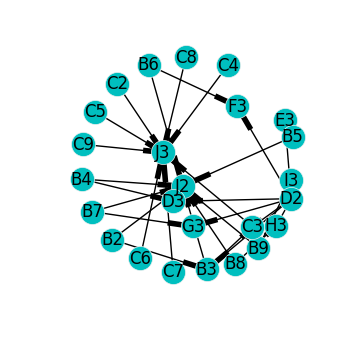

In [14]:
pos=nx.spring_layout(G)

pl.figure(figsize=(3,3))
nx.draw(G, node_color='c', edge_color='k', with_labels=True, nodes=['J3' ])
#nx.draw_random(G)
#nx.draw_circular(G)
#nx.draw_spectral(G)

#nx.draw_networkx_nodes(G,pos,alpha=0.8)
#nx.draw_networkx_labels(G,pos,AllCells,font_size=8);
d = json_graph.node_link_data(G, ) 

In [28]:
%%html
<script src="//d3js.org/d3.v3.min.js"></script>
<style>
.link {stroke: #ccc;}
.node text {  pointer-events: none;font: 10px sans-serif;}
</style>
<div id="chart"></div>

<script>
var width = 1024, height = 400

var svg  = d3.select("#chart").append("svg").attr("width", width).attr("height", height);
var force = d3.layout.force().gravity(0.05).distance(100).charge(-100).size([width, height]);

//node.append("image").attr("xlink:href", "https://github.com/favicon.ico").attr("x", -8).attr("y", -8).attr("width", 16).attr("height", 16);

fill = d3.scale.category20();
       
function d3json(json, displayField, groupColor, radius, charge) {
  force.nodes(json.nodes).links(json.links).start();
  var link = svg.selectAll(".link").data(json.links).enter().append("line").attr("class", "link");
  var node = svg.selectAll(".node").data(json.nodes).enter().append("g").attr("class", "node")
        .attr('charge', function(d) { d.r < 10 ?  -13500: 20})
        .call(force.drag);

  node.append("text").attr("dx", 12).attr("dy", ".45em").text(function(d) { return displayField? d[displayField] : '' });
  node.append("svg:circle")
    .attr("class", "node")
    .attr("x", function(d) { return d.x; })
    .attr("y", function(d) { return d.y; })
    .attr("r", function(d) { return radius? d[radius]: 8; })
    .style("fill", function(d) { return groupColor? fill(d[groupColor]): fill(0); })
        
  force.on("tick", function() {
    link.attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node.attr("transform", function(d) { return "translate(" + d.x + "," + d.y + ")"; });
  });
};
</script>

<script>
function d3json1(json, displayField, groupColor) {
    gg = displayField? "d[displayField]" : 'sada'
    alert(gg)
}
//jj1={"nodes":[{"name":"Myriel","group":1},{"name":"Napoleon","group":1},{"name":"Mlle.Baptistine","group":1},{"name":"Mme.Magloire","group":1},{"name":"CountessdeLo","group":1},{"name":"Geborand","group":1},{"name":"Champtercier","group":1},{"name":"Cravatte","group":1},{"name":"Count","group":1},{"name":"OldMan","group":1},{"name":"Labarre","group":2},{"name":"Valjean","group":2},{"name":"Marguerite","group":3},{"name":"Mme.deR","group":2},{"name":"Isabeau","group":2},{"name":"Gervais","group":2},{"name":"Tholomyes","group":3},{"name":"Listolier","group":3},{"name":"Fameuil","group":3},{"name":"Blacheville","group":3},{"name":"Favourite","group":3},{"name":"Dahlia","group":3},{"name":"Zephine","group":3},{"name":"Fantine","group":3},{"name":"Mme.Thenardier","group":4},{"name":"Thenardier","group":4},{"name":"Cosette","group":5},{"name":"Javert","group":4},{"name":"Fauchelevent","group":0},{"name":"Bamatabois","group":2},{"name":"Perpetue","group":3},{"name":"Simplice","group":2},{"name":"Scaufflaire","group":2},{"name":"Woman1","group":2},{"name":"Judge","group":2},{"name":"Champmathieu","group":2},{"name":"Brevet","group":2},{"name":"Chenildieu","group":2},{"name":"Cochepaille","group":2},{"name":"Pontmercy","group":4},{"name":"Boulatruelle","group":6},{"name":"Eponine","group":4},{"name":"Anzelma","group":4},{"name":"Woman2","group":5},{"name":"MotherInnocent","group":0},{"name":"Gribier","group":0},{"name":"Jondrette","group":7},{"name":"Mme.Burgon","group":7},{"name":"Gavroche","group":8},{"name":"Gillenormand","group":5},{"name":"Magnon","group":5},{"name":"Mlle.Gillenormand","group":5},{"name":"Mme.Pontmercy","group":5},{"name":"Mlle.Vaubois","group":5},{"name":"Lt.Gillenormand","group":5},{"name":"Marius","group":8},{"name":"BaronessT","group":5},{"name":"Mabeuf","group":8},{"name":"Enjolras","group":8},{"name":"Combeferre","group":8},{"name":"Prouvaire","group":8},{"name":"Feuilly","group":8},{"name":"Courfeyrac","group":8},{"name":"Bahorel","group":8},{"name":"Bossuet","group":8},{"name":"Joly","group":8},{"name":"Grantaire","group":8},{"name":"MotherPlutarch","group":9},{"name":"Gueulemer","group":4},{"name":"Babet","group":4},{"name":"Claquesous","group":4},{"name":"Montparnasse","group":4},{"name":"Toussaint","group":5},{"name":"Child1","group":10},{"name":"Child2","group":10},{"name":"Brujon","group":4},{"name":"Mme.Hucheloup","group":8}],"links":[{"source":1,"target":0,"value":1},{"source":2,"target":0,"value":8},{"source":3,"target":0,"value":10},{"source":3,"target":2,"value":6},{"source":4,"target":0,"value":1},{"source":5,"target":0,"value":1},{"source":6,"target":0,"value":1},{"source":7,"target":0,"value":1},{"source":8,"target":0,"value":2},{"source":9,"target":0,"value":1},{"source":11,"target":10,"value":1},{"source":11,"target":3,"value":3},{"source":11,"target":2,"value":3},{"source":11,"target":0,"value":5},{"source":12,"target":11,"value":1},{"source":13,"target":11,"value":1},{"source":14,"target":11,"value":1},{"source":15,"target":11,"value":1},{"source":17,"target":16,"value":4},{"source":18,"target":16,"value":4},{"source":18,"target":17,"value":4},{"source":19,"target":16,"value":4},{"source":19,"target":17,"value":4},{"source":19,"target":18,"value":4},{"source":20,"target":16,"value":3},{"source":20,"target":17,"value":3},{"source":20,"target":18,"value":3},{"source":20,"target":19,"value":4},{"source":21,"target":16,"value":3},{"source":21,"target":17,"value":3},{"source":21,"target":18,"value":3},{"source":21,"target":19,"value":3},{"source":21,"target":20,"value":5},{"source":22,"target":16,"value":3},{"source":22,"target":17,"value":3},{"source":22,"target":18,"value":3},{"source":22,"target":19,"value":3},{"source":22,"target":20,"value":4},{"source":22,"target":21,"value":4},{"source":23,"target":16,"value":3},{"source":23,"target":17,"value":3},{"source":23,"target":18,"value":3},{"source":23,"target":19,"value":3},{"source":23,"target":20,"value":4},{"source":23,"target":21,"value":4},{"source":23,"target":22,"value":4},{"source":23,"target":12,"value":2},{"source":23,"target":11,"value":9},{"source":24,"target":23,"value":2},{"source":24,"target":11,"value":7},{"source":25,"target":24,"value":13},{"source":25,"target":23,"value":1},{"source":25,"target":11,"value":12},{"source":26,"target":24,"value":4},{"source":26,"target":11,"value":31},{"source":26,"target":16,"value":1},{"source":26,"target":25,"value":1},{"source":27,"target":11,"value":17},{"source":27,"target":23,"value":5},{"source":27,"target":25,"value":5},{"source":27,"target":24,"value":1},{"source":27,"target":26,"value":1},{"source":28,"target":11,"value":8},{"source":28,"target":27,"value":1},{"source":29,"target":23,"value":1},{"source":29,"target":27,"value":1},{"source":29,"target":11,"value":2},{"source":30,"target":23,"value":1},{"source":31,"target":30,"value":2},{"source":31,"target":11,"value":3},{"source":31,"target":23,"value":2},{"source":31,"target":27,"value":1},{"source":32,"target":11,"value":1},{"source":33,"target":11,"value":2},{"source":33,"target":27,"value":1},{"source":34,"target":11,"value":3},{"source":34,"target":29,"value":2},{"source":35,"target":11,"value":3},{"source":35,"target":34,"value":3},{"source":35,"target":29,"value":2},{"source":36,"target":34,"value":2},{"source":36,"target":35,"value":2},{"source":36,"target":11,"value":2},{"source":36,"target":29,"value":1},{"source":37,"target":34,"value":2},{"source":37,"target":35,"value":2},{"source":37,"target":36,"value":2},{"source":37,"target":11,"value":2},{"source":37,"target":29,"value":1},{"source":38,"target":34,"value":2},{"source":38,"target":35,"value":2},{"source":38,"target":36,"value":2},{"source":38,"target":37,"value":2},{"source":38,"target":11,"value":2},{"source":38,"target":29,"value":1},{"source":39,"target":25,"value":1},{"source":40,"target":25,"value":1},{"source":41,"target":24,"value":2},{"source":41,"target":25,"value":3},{"source":42,"target":41,"value":2},{"source":42,"target":25,"value":2},{"source":42,"target":24,"value":1},{"source":43,"target":11,"value":3},{"source":43,"target":26,"value":1},{"source":43,"target":27,"value":1},{"source":44,"target":28,"value":3},{"source":44,"target":11,"value":1},{"source":45,"target":28,"value":2},{"source":47,"target":46,"value":1},{"source":48,"target":47,"value":2},{"source":48,"target":25,"value":1},{"source":48,"target":27,"value":1},{"source":48,"target":11,"value":1},{"source":49,"target":26,"value":3},{"source":49,"target":11,"value":2},{"source":50,"target":49,"value":1},{"source":50,"target":24,"value":1},{"source":51,"target":49,"value":9},{"source":51,"target":26,"value":2},{"source":51,"target":11,"value":2},{"source":52,"target":51,"value":1},{"source":52,"target":39,"value":1},{"source":53,"target":51,"value":1},{"source":54,"target":51,"value":2},{"source":54,"target":49,"value":1},{"source":54,"target":26,"value":1},{"source":55,"target":51,"value":6},{"source":55,"target":49,"value":12},{"source":55,"target":39,"value":1},{"source":55,"target":54,"value":1},{"source":55,"target":26,"value":21},{"source":55,"target":11,"value":19},{"source":55,"target":16,"value":1},{"source":55,"target":25,"value":2},{"source":55,"target":41,"value":5},{"source":55,"target":48,"value":4},{"source":56,"target":49,"value":1},{"source":56,"target":55,"value":1},{"source":57,"target":55,"value":1},{"source":57,"target":41,"value":1},{"source":57,"target":48,"value":1},{"source":58,"target":55,"value":7},{"source":58,"target":48,"value":7},{"source":58,"target":27,"value":6},{"source":58,"target":57,"value":1},{"source":58,"target":11,"value":4},{"source":59,"target":58,"value":15},{"source":59,"target":55,"value":5},{"source":59,"target":48,"value":6},{"source":59,"target":57,"value":2},{"source":60,"target":48,"value":1},{"source":60,"target":58,"value":4},{"source":60,"target":59,"value":2},{"source":61,"target":48,"value":2},{"source":61,"target":58,"value":6},{"source":61,"target":60,"value":2},{"source":61,"target":59,"value":5},{"source":61,"target":57,"value":1},{"source":61,"target":55,"value":1},{"source":62,"target":55,"value":9},{"source":62,"target":58,"value":17},{"source":62,"target":59,"value":13},{"source":62,"target":48,"value":7},{"source":62,"target":57,"value":2},{"source":62,"target":41,"value":1},{"source":62,"target":61,"value":6},{"source":62,"target":60,"value":3},{"source":63,"target":59,"value":5},{"source":63,"target":48,"value":5},{"source":63,"target":62,"value":6},{"source":63,"target":57,"value":2},{"source":63,"target":58,"value":4},{"source":63,"target":61,"value":3},{"source":63,"target":60,"value":2},{"source":63,"target":55,"value":1},{"source":64,"target":55,"value":5},{"source":64,"target":62,"value":12},{"source":64,"target":48,"value":5},{"source":64,"target":63,"value":4},{"source":64,"target":58,"value":10},{"source":64,"target":61,"value":6},{"source":64,"target":60,"value":2},{"source":64,"target":59,"value":9},{"source":64,"target":57,"value":1},{"source":64,"target":11,"value":1},{"source":65,"target":63,"value":5},{"source":65,"target":64,"value":7},{"source":65,"target":48,"value":3},{"source":65,"target":62,"value":5},{"source":65,"target":58,"value":5},{"source":65,"target":61,"value":5},{"source":65,"target":60,"value":2},{"source":65,"target":59,"value":5},{"source":65,"target":57,"value":1},{"source":65,"target":55,"value":2},{"source":66,"target":64,"value":3},{"source":66,"target":58,"value":3},{"source":66,"target":59,"value":1},{"source":66,"target":62,"value":2},{"source":66,"target":65,"value":2},{"source":66,"target":48,"value":1},{"source":66,"target":63,"value":1},{"source":66,"target":61,"value":1},{"source":66,"target":60,"value":1},{"source":67,"target":57,"value":3},{"source":68,"target":25,"value":5},{"source":68,"target":11,"value":1},{"source":68,"target":24,"value":1},{"source":68,"target":27,"value":1},{"source":68,"target":48,"value":1},{"source":68,"target":41,"value":1},{"source":69,"target":25,"value":6},{"source":69,"target":68,"value":6},{"source":69,"target":11,"value":1},{"source":69,"target":24,"value":1},{"source":69,"target":27,"value":2},{"source":69,"target":48,"value":1},{"source":69,"target":41,"value":1},{"source":70,"target":25,"value":4},{"source":70,"target":69,"value":4},{"source":70,"target":68,"value":4},{"source":70,"target":11,"value":1},{"source":70,"target":24,"value":1},{"source":70,"target":27,"value":1},{"source":70,"target":41,"value":1},{"source":70,"target":58,"value":1},{"source":71,"target":27,"value":1},{"source":71,"target":69,"value":2},{"source":71,"target":68,"value":2},{"source":71,"target":70,"value":2},{"source":71,"target":11,"value":1},{"source":71,"target":48,"value":1},{"source":71,"target":41,"value":1},{"source":71,"target":25,"value":1},{"source":72,"target":26,"value":2},{"source":72,"target":27,"value":1},{"source":72,"target":11,"value":1},{"source":73,"target":48,"value":2},{"source":74,"target":48,"value":2},{"source":74,"target":73,"value":3},{"source":75,"target":69,"value":3},{"source":75,"target":68,"value":3},{"source":75,"target":25,"value":3},{"source":75,"target":48,"value":1},{"source":75,"target":41,"value":1},{"source":75,"target":70,"value":1},{"source":75,"target":71,"value":1},{"source":76,"target":64,"value":1},{"source":76,"target":65,"value":1},{"source":76,"target":66,"value":1},{"source":76,"target":63,"value":1},{"source":76,"target":62,"value":1},{"source":76,"target":48,"value":1},{"source":76,"target":58,"value":1}]}
jj2= {'graph': {}, 'directed': true, 'multigraph': false, 
      'links': [{'source': 0, 'target': 7}, {'source': 0, 'target': 9}, {'source': 1, 'target': 3}, {'source': 2, 'target': 3}, {'source': 4, 'target': 3}, {'source': 5, 'target': 9}, {'source': 5, 'target': 24}, {'source': 6, 'target': 3}, {'source': 8, 'target': 3}, {'source': 10, 'target': 19}, {'source': 10, 'target': 9}, {'source': 11, 'target': 17}, {'source': 11, 'target': 9}, {'source': 12, 'target': 3}, {'source': 14, 'target': 7}, {'source': 14, 'target': 17}, {'source': 14, 'target': 18}, {'source': 14, 'target': 19}, {'source': 14, 'target': 13}, {'source': 14, 'target': 16}, {'source': 14, 'target': 5}, {'source': 14, 'target': 24}, {'source': 15, 'target': 3}, {'source': 20, 'target': 18}, {'source': 20, 'target': 9}, {'source': 21, 'target': 5}, {'source': 21, 'target': 9}, {'source': 22, 'target': 13}, {'source': 22, 'target': 9}, {'source': 23, 'target': 16}, {'source': 23, 'target': 9}, {'source': 24, 'target': 3}], 
      'nodes': [{'id': 'B7', 'fixed': false, 'r': 8, 'group': 13}, {'id': 'C8', 'fixed': false, 'r': 8, 'group': 17}, {'id': 'C2', 'fixed': false, 'r': 8, 'group': 17}, {'id': 'J3', 'fixed': true, 'r': 12, 'group': 16}, {'id': 'C4', 'fixed': false, 'r': 8, 'group': 17}, {'id': 'B3', 'fixed': false, 'r': 8, 'group': 13}, {'id': 'C6', 'fixed': false, 'r': 8, 'group': 17}, {'id': 'G3', 'fixed': true, 'r': 12, 'group': 2}, {'id': 'C5', 'fixed': false, 'r': 8, 'group': 17}, {'id': 'J2', 'fixed': true, 'r': 12, 'group': 12}, {'id': 'B9', 'fixed': false, 'r': 8, 'group': 15}, {'id': 'B4', 'fixed': false, 'r': 8, 'group': 13}, {'id': 'C9', 'fixed': false, 'r': 8, 'group': 17}, {'id': 'E3', 'fixed': true, 'r': 12, 'group': 18}, {'id': 'D2', 'fixed': false, 'r': 8, 'group': 19}, {'id': 'C7', 'fixed': false, 'r': 8, 'group': 17}, {'id': 'F3', 'fixed': true, 'r': 12, 'group': 0}, {'id': 'D3', 'fixed': true, 'r': 12, 'group': 10}, {'id': 'H3', 'fixed': true, 'r': 12, 'group': 4}, {'id': 'I3', 'fixed': true, 'r': 12, 'group': 14}, {'id': 'B8', 'fixed': false, 'r': 8, 'group': 13}, {'id': 'B2', 'fixed': false, 'r': 8, 'group': 13}, {'id': 'B5', 'fixed': false, 'r': 8, 'group': 19}, {'id': 'B6', 'fixed': false, 'r': 8, 'group': 13}, {'id': 'C3', 'fixed': false, 'r': 8, 'group': 17}]}

d3json(jj2, 'id', 'group', 'r')
d3json1
</script>

In [ ]:
F3       , =B6/$D$2 [['B6'], ['D2']]
G3       , =B7/$D$2 [['B7'], ['D2']]
H3       , =B8/$D$2 [['B8'], ['D2']]
B3       , =B2/$D$2 [['B2'], ['D2']]
C3       , =B3/$D$2 [['B3'], ['D2']]
D3       , =B4/$D$2 [['B4'], ['D2']]
J2       , =SUM(B2:B9) [['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']]
I3       , =B9/$D$2 [['B9'], ['D2']]
J3       , =SUM(C2:C9) [['C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']]
E3       , =B5/$D$2 [['B5'], ['D2']]